In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.linalg as la
import itertools
from tqdm.auto import tqdm

In [2]:
import mctspy as mct

In [3]:
def finger (kappa0, gammadot, t):
    gt = gammadot*t
    F = la.expm(kappa0*gt)
    return np.dot(F,F.T)
def dB (kappa0, gammadot, t):
    B = finger(kappa0, gammadot, t)
    return (kappa0 @ B + B @ kappa0.T) * gammadot
def dBinv (kappa0, gammadot, t):
    Binv = la.inv(finger(kappa0, gammadot, t))
    return (kappa0.T @ Binv + Binv @ kappa0) * (-gammadot)

In [4]:
kappa0 = np.array([[0,1,0],[0,0,0],[0,0,0]])

In [5]:
gammadot = 10**np.linspace(0,-9,10)
sigma = np.zeros((gammadot.shape[0], 3, 3))

In [6]:
v1c, v2c = 2*(np.sqrt(2.)-1), 2.0
v1, v2 = v1c - 1e-3/(np.sqrt(2)-1), v2c
for i,gdot in enumerate(gammadot):
    model = mct.f12gammadot_tensorial_model (v1, v2, gammadot=gdot, gammac=0.1,
                                             use_hhat=True, nu=1.0, kappa=kappa0)
    phi = mct.correlator (model = model, store = True)
    correlators = mct.CorrelatorStack([phi])
    correlators.solve_all(stop_on_zero=True)
    #dB_ = np.array([dB(kappa0,gdot,t) for t in phi.t]).reshape(-1,3,3)
    #sigma[i] = scipy.integrate.trapezoid(dB_ * phi.phi[:,0,None,None]**2, x=phi.t, axis=0)
    sigma[i] = scipy.integrate.trapezoid(phi.shear_modulus(lc=False), x=phi.t, axis=0)

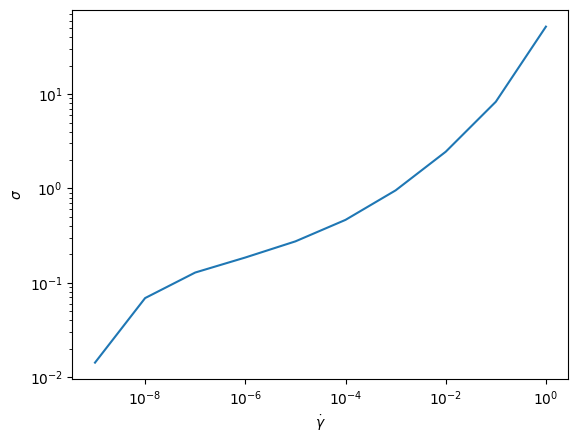

In [7]:
plt.plot(gammadot, 100*sigma[:,0,1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\dot\gamma$')
plt.ylabel(r'$\sigma$')
plt.show()

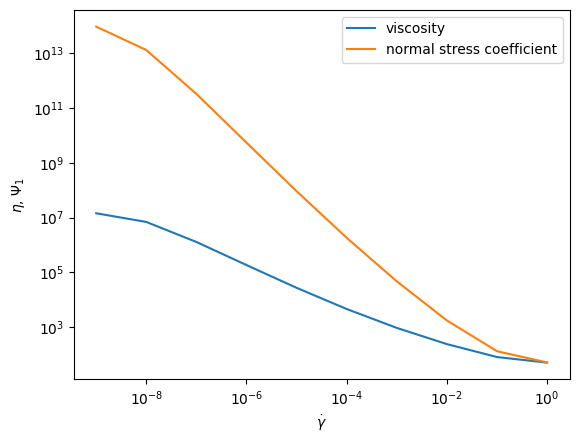

In [8]:
plt.plot(gammadot, 100*sigma[:,0,1]/gammadot, label='viscosity')
plt.plot(gammadot, 100*sigma[:,0,0]/gammadot**2, label='normal stress coefficient')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\dot\gamma$')
plt.ylabel(r'$\eta$, $\Psi_1$')
plt.legend()
plt.show()

In [9]:
kappa0ext = np.array([[1,0,0],[0,-1,0],[0,0,0]])
sigmaext = np.zeros((gammadot.shape[0],3,3))
sigmaext_lc = np.zeros((gammadot.shape[0],3,3))

In [10]:
v1c, v2c = 2*(np.sqrt(2.)-1), 2.0
v1, v2 = v1c - 1e-3/(np.sqrt(2)-1), v2c
for i,gdot in enumerate(gammadot):
    model = mct.f12gammadot_tensorial_model (v1, v2, gammadot=gdot, gammac=0.1,
                                             use_hhat=True, nu=1.0, kappa=kappa0ext)
    phi = mct.correlator (model = model, store = True)
    correlators = mct.CorrelatorStack([phi])
    correlators.solve_all(stop_on_zero=True)
    #dB_ = np.array([dB(kappa0ext,gdot,t) for t in phi.t]).reshape(-1,3,3)
    sigmaext[i] = scipy.integrate.trapezoid(phi.shear_modulus(lc=False), x=phi.t, axis=0)
    sigmaext_lc[i] = scipy.integrate.trapezoid(phi.shear_modulus(lc=True), x=phi.t, axis=0)

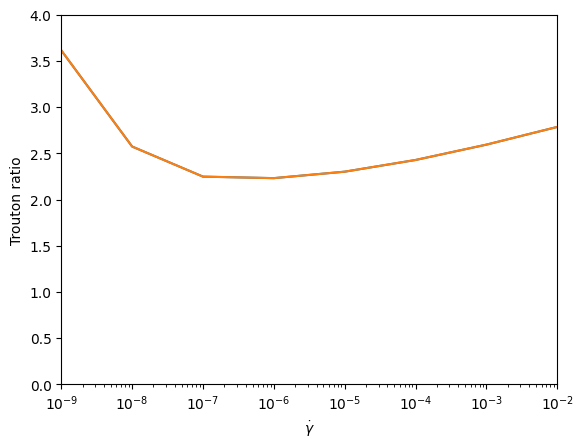

In [11]:
plt.plot(gammadot, (sigmaext[:,0,0]-sigmaext[:,1,1])/sigma[:,0,1])
plt.plot(gammadot, (sigmaext_lc[:,0,0]-sigmaext_lc[:,1,1])/sigma[:,0,1])
plt.xscale('log')
plt.xlim(1e-9,1e-2)
plt.ylim(0,4)
plt.xlabel(r'$\dot\gamma$')
plt.ylabel('Trouton ratio')
plt.show()

In [12]:
def calc_sigma(kappa,gammadot,lc=False):
    v1c, v2c = 2*(np.sqrt(2.)-1), 2.0
    v1, v2 = v1c + 1e-3/(np.sqrt(2)-1), v2c
    model = mct.f12gammadot_tensorial_model (v1, v2, gammadot=gammadot, gammac=0.1,
                                             use_hhat=True, nu=1.0, kappa=kappa)
    phi = mct.correlator (model=model, store=True)
    phi.solve_all(stop_on_zero=True)
    sigma = scipy.integrate.trapezoid(phi.shear_modulus(lc=lc), x=phi.t, axis=0)
    return sigma
def gen_yield_surface(kappagen,**kwargs):
    kappas,sigy = [],[]
    for kappa in tqdm(kappagen()):
        sigtens = calc_sigma(kappa,1e-9,**kwargs)
        kappas.append(kappa)
        sigy.append(sigtens)
    return np.array(kappas),np.array(sigy)

In [13]:
def kappa_pnas(A,B,C):
    return np.array([[B,C,0],[0,-(A+B)/2,0],[0,0,(A-B)/2]])
def pnas_family():
    for A in np.linspace(-1,1,9):
        yield kappa_pnas(A=A,B=1,C=0)

In [14]:
def kappadiag(ex,ey,ez):
    return np.array([[ex,0,0],[0,ey,0],[0,0,ez]])
def s_family():
    for A in np.linspace(-1,1,9):
        for B in np.linspace(-1,1,3):
            if np.isclose(A,0) and np.isclose(B,0): continue
            yield kappadiag(A,B,-(A+B))

In [15]:
kappas, sigs = gen_yield_surface(s_family, lc=False)

0it [00:00, ?it/s]

In [16]:
def lode_coordinates(sigma):
    s1,s2,s3 = la.eig(sigma)[0]
    x = (s2.real-s1.real)/np.sqrt(2.)
    y = (2*s3.real-s1.real-s2.real)/np.sqrt(6.)
    z = np.trace(sigma)/np.sqrt(3.)
    return x,y,z
def all_lode_coordinates(sigma):
    s = np.array(list(itertools.permutations(la.eig(sigma)[0].real))).T
    x = (s[1]-s[0])/np.sqrt(2.)
    y = (2*s[2]-s[1]-s[0])/np.sqrt(6.)
    z = (s[0]+s[1]+s[2])/np.sqrt(3.)
    return x,y,z
def principal_stress_differences(sigma):
    s = np.array(list(itertools.permutations(la.eig(sigma)[0].real))).T
    x = s[0]-s[1]-(s[0]+s[1]+s[2])/3
    y = s[1]-s[2]-(s[0]+s[1]+s[2])/3
    return x,y
def sorted_yield_surface_points(sigma_list):
    allx,ally = [],[]
    for stens in sigma_list:
        x,y,_ = all_lode_coordinates(stens)
        allx.append(x)
        ally.append(y)
    allx=np.array(allx).reshape(-1)
    ally=np.array(ally).reshape(-1)
    skey = np.argsort(np.arctan2(ally,allx))
    return allx[skey],ally[skey]

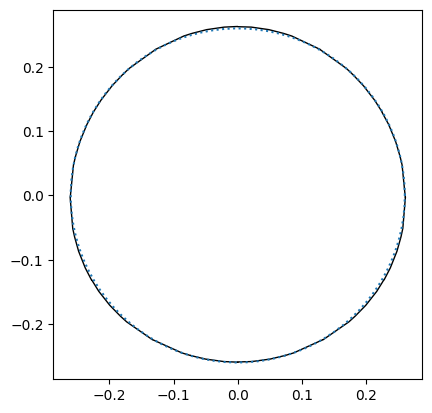

In [17]:
plt.fill(*sorted_yield_surface_points(100*sigs),fill=False,linestyle='solid')
#plt.plot(*sorted_yield_surface_points(100*sigs),'o')
alpha = np.linspace(0,2.*np.pi,100)
R = 0.26
plt.plot(R*np.cos(alpha),R*np.sin(alpha),linestyle='dotted')
plt.gca().set_aspect('equal')
plt.show()